In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re
import demoji
from sklearn.model_selection import train_test_split, GridSearchCV
pd.set_option('display.max_colwidth', 50)

%matplotlib inline

In [28]:
df = pd.read_csv('./comments_and_tags.csv', sep = ',', index_col = 'Unnamed: 0')
# make the 3 class problem into a binary problem
df['sentiment_binary'] = df['sentiment'].apply(lambda x: 1 if x == 1 else 0 )
df=df.reset_index()
df.head()

,index,id,sentiment,search_term,tagger,author,body,created_utc,link_id,permalink,score,subreddit,post_name,filename,sentiment_binary
0,0,glngetr,0,ladvc3,SUPRATIK,nevabraun,Thanks but you’ve lost me at \n\n„If look at A...,1612214426,t3_ladvc3,/r/wallstreetbets/comments/ladvc3/just_bought_...,21,wallstreetbets,"Just bought 860 of AMC, greetings from Germany...",comments_batch_6.csv,0
1,1,glndurd,1,ladvc3,SUPRATIK,Awake_4E,Awesome 😎! Why the moon 🤔 Let’s shoot AMC out ...,1612213448,t3_ladvc3,/r/wallstreetbets/comments/ladvc3/just_bought_...,25,wallstreetbets,"Just bought 860 of AMC, greetings from Germany...",comments_batch_6.csv,1
2,2,glndfos,1,ladvc3,SUPRATIK,Cloud9forreal,If you look at AMCs business page you’ll find ...,1612213289,t3_ladvc3,/r/wallstreetbets/comments/ladvc3/just_bought_...,58,wallstreetbets,"Just bought 860 of AMC, greetings from Germany...",comments_batch_6.csv,1
3,3,glnd58d,1,ladvc3,SUPRATIK,MacCoy69,"I bought 20 today, i am also a retarded dumb m...",1612213186,t3_ladvc3,/r/wallstreetbets/comments/ladvc3/just_bought_...,13,wallstreetbets,"Just bought 860 of AMC, greetings from Germany...",comments_batch_6.csv,1
4,4,glnd2xt,0,ladvc3,SUPRATIK,Menuler,"Ahh, my fellow Retard. I see the more and more...",1612213163,t3_ladvc3,/r/wallstreetbets/comments/ladvc3/just_bought_...,11,wallstreetbets,"Just bought 860 of AMC, greetings from Germany...",comments_batch_6.csv,0


In [29]:
def find_pos(word):
    # Part of Speech constants
    # ADJ, ADJ_SAT, ADV, NOUN, VERB = 'a', 's', 'r', 'n', 'v'
    pos= nltk.pos_tag(nltk.word_tokenize(word))[0][1]
    # Adjective tags -'JJ', 'JJR', 'JJS'
    if pos.lower()[0] == 'j':
        return 'a'
    # Adverb tags -'RB', 'RBR', 'RBS'
    elif pos.lower()[0] == 'r':
        return 'r'
    # Verb tags -'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'
    elif pos.lower()[0] == 'v':
        return 'v'
    # Noun tags -'NN', 'NNS', 'NNP', 'NNPS'
    else:
        return 'n'

demoji.download_codes()

def remove_emoji(text):
    dem = demoji.findall(text)
    for item in dem.keys():
        text = text.replace(item,'')
        
    return text

# Function to apply lemmatization to a list of words
def words_lemmatizer(text, encoding="utf8"):
    words = nltk.word_tokenize(text)
    lemma_words = []
    wl= WordNetLemmatizer()
    for word in words:
        pos= find_pos(word)
        lemma_words.append(wl.lemmatize(word, pos))
    return " ".join(lemma_words)

def remove_stopwords(text, lang='english'):
    new_words = ['already','also','comment','delete','even','literally','lolol','lololol','lolz','lols','lot','loll','lolololol','lolll','mean','na',
                 'point','post','probably','put','reddit','remove','see','something','want','well'] #first 200 in dictionary_all #insert all additional stopwords you want to remove here 
    custom = nltk.corpus.stopwords.words('english')
    custom.extend(new_words)
    words = nltk.word_tokenize(text)
    lang_stopwords = stopwords.words(lang)
    stopwords_removed = [w for w in words if w.lower() not in lang_stopwords]
    removing_custom_words = [words for words in stopwords_removed if not words in custom]
    return " ".join(removing_custom_words)

def do_prepocessing(one_row):
    lower_text = one_row.lower()
    
    remove_url = re.sub(r'http\S+', '',lower_text) # Remove URL
    
    remove_emoji_text = remove_emoji(remove_url) # Remove emojis

    remove_unwanted_charectors = re.sub(r'[^a-zA-Z0-9_#@&\s]', ' ', remove_emoji_text) # Remove unwanted charectors like punctuations andnon ascii 
    remove_unwanted_charectors = re.sub(r'&[\w]+', ' ', remove_unwanted_charectors) # Remove &amp, *&words etc
    
    removed_extra_space = re.sub(r'\s+',' ', remove_unwanted_charectors) # Remove extra white_spaces
    
    extract_hash = re.findall(r'#[\w]+', removed_extra_space) # Extract #hashTags
    extract_has_joined = " ".join(extract_hash)
    removed_hash_text = re.sub(r'#[\w]+', '', removed_extra_space) # Remove #hastags
    
    remove_atrate = re.findall(r'@[\w]+', removed_hash_text) # Extract @Users
    removed_atrate = re.sub(r'@[\w]+', '', removed_hash_text) # Remove @Users
    
    removed_stopwords_text = remove_stopwords(removed_atrate)
    lemmatize_text = words_lemmatizer(removed_stopwords_text)
    return lemmatize_text

In [30]:
# Preprocessing

df['body'] = df['body'].astype(str)
df['body'] = df['body'].apply(do_prepocessing)

In [31]:
from nltk.corpus import stopwords

top_n = 250

#create new df with only body and sentiment
dfNew = df[['body','sentiment_binary']]

# create sparse matrix with 1-gram and 2-gram
stop = set(stopwords.words('english'))
corpus = dfNew.loc[:,'body']
tfidf = TfidfVectorizer(ngram_range=(1,2), stop_words=list(stop))
vectorized = tfidf.fit_transform(corpus)

#convert to dense matrix
vocab = tfidf.get_feature_names()
df_vectorized= pd.DataFrame(vectorized.todense(),columns=vocab)

#top k features
indices = np.argsort(tfidf.idf_)
features = tfidf.get_feature_names()
top_features = [features[i] for i in indices[:top_n]]

#df with only top features
df_top_vectorized = df_vectorized[top_features]

# combine with dfNew
df_combined = pd.concat([dfNew, df_top_vectorized], axis=1)
df_combined

,body,sentiment_binary,clov,amc,clne,go,get,bb,share,buy,...,trade,account,damn,ride,bullish,guess,rich,pop,000,16
0,thanks lose look amcs business page,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,awesome moon let shoot amc solar system,1,0.00,0.11,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,look amcs business page find actually business...,1,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,bought 20 today retard dumb money ape germany ...,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,ahh fellow retard people get pessimistic gme a...,0,0.00,0.08,0.00,0.00,0.09,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5484,hold 200 bb share hit moon,1,0.00,0.00,0.00,0.00,0.00,0.16,0.16,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5485,b ippity b oppity give zoppity,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5486,lol really force bb thing eh,0,0.00,0.00,0.00,0.00,0.00,0.14,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5487,,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [32]:
X = df_combined.drop(['body','sentiment_binary'],axis=1)
y = df_combined['sentiment_binary']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [34]:
import lazypredict
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric = None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
print(models)
# this is the score for top 250 terms with 1-gram and 2-gram

100%|██████████| 29/29 [00:44<00:00,  1.54s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
NearestCentroid                    0.70               0.69     0.69      0.70   
LGBMClassifier                     0.70               0.69     0.69      0.70   
LogisticRegression                 0.69               0.68     0.68      0.68   
XGBClassifier                      0.69               0.68     0.68      0.68   
LinearDiscriminantAnalysis         0.69               0.68     0.68      0.68   
RidgeClassifierCV                  0.69               0.68     0.68      0.68   
RidgeClassifier                    0.69               0.68     0.68      0.68   
CalibratedClassifierCV             0.68               0.67     0.67      0.68   
BernoulliNB                        0.68               0.67     0.67      0.68   
LinearSVC                          0.68               0.67     0.67      0.68   
ExtraTreesClassifier        

[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Indexed 3842 samples in 0.098s...
[t-SNE] Computed neighbors for 3842 samples in 6.529s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3842
[t-SNE] Computed conditional probabilities for sample 2000 / 3842
[t-SNE] Computed conditional probabilities for sample 3000 / 3842
[t-SNE] Computed conditional probabilities for sample 3842 / 3842
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.306038
[t-SNE] KL divergence after 1000 iterations: 2.416067


[Text(0.5, 1.0, 'WSB data T-SNE projection')]

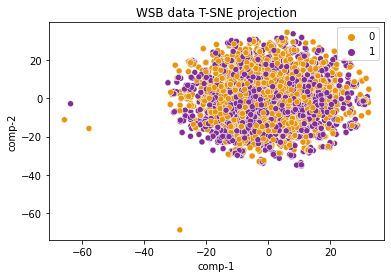

In [18]:
#visualize using TSNE

tsne = TSNE(n_components=2, verbose=1, random_state=1, perplexity=70)
X_train_transformed = tsne.fit_transform(X_train)
df_plot = pd.DataFrame()
df_plot["y"] = y_train
df_plot["comp-1"] = X_train_transformed[:,0]
df_plot["comp-2"] = X_train_transformed[:,1]
sns.scatterplot(x="comp-1", y="comp-2", hue=df_plot.y.tolist(),
                    palette=sns.color_palette("CMRmap_r", 2),
                    data=df_plot).set(title="WSB data T-SNE projection")

In [57]:
# adding bert and vader to the data
df2 = pd.read_csv('./comments_tags_vader and bert scores.csv', sep = ',', index_col = 'Unnamed: 0')
df2['sentiment_binary'] = df2['sentiment'].apply(lambda x: 1 if x == 1 else 0 )
df2.head()

,id,sentiment,search_term,tagger,author,body,created_utc,link_id,permalink,score,...,filename,vader_sentiment,sentiment_binary,vader_sentiment_binary,neg_score,neut_score,pos_score,final_score,Class_0 Logits BERT,CLass_1 Logits BERT
0,glngetr,0,ladvc3,SUPRATIK,nevabraun,Thanks but you’ve lost me at \n\n„If look at A...,1612214426,t3_ladvc3,/r/wallstreetbets/comments/ladvc3/just_bought_...,21,...,comments_batch_6.csv,-1,0,0,0.14,0.78,0.09,-0.25,1.81,-2.00
1,glndurd,1,ladvc3,SUPRATIK,Awake_4E,Awesome 😎! Why the moon 🤔 Let’s shoot AMC out ...,1612213448,t3_ladvc3,/r/wallstreetbets/comments/ladvc3/just_bought_...,25,...,comments_batch_6.csv,1,1,1,0.06,0.52,0.42,0.95,-1.76,1.84
2,glndfos,1,ladvc3,SUPRATIK,Cloud9forreal,If you look at AMCs business page you’ll find ...,1612213289,t3_ladvc3,/r/wallstreetbets/comments/ladvc3/just_bought_...,58,...,comments_batch_6.csv,1,1,1,0.03,0.62,0.35,0.96,-1.79,1.77
3,glnd58d,1,ladvc3,SUPRATIK,MacCoy69,"I bought 20 today, i am also a retarded dumb m...",1612213186,t3_ladvc3,/r/wallstreetbets/comments/ladvc3/just_bought_...,13,...,comments_batch_6.csv,1,1,1,0.08,0.29,0.64,0.98,-1.56,1.84
4,glnd2xt,1,ladvc3,SUPRATIK,Menuler,"Ahh, my fellow Retard. I see the more and more...",1612213163,t3_ladvc3,/r/wallstreetbets/comments/ladvc3/just_bought_...,11,...,comments_batch_6.csv,-1,1,0,0.22,0.71,0.07,-0.61,-1.82,1.99


In [58]:
# Preprocessing

df2['body'] = df2['body'].astype(str)
df2['body'] = df2['body'].apply(do_prepocessing)

In [59]:
top_n = 250

#create new df with only body and sentiment and other bert/ vader columns
dfNew2 = df2[['body','sentiment_binary','neg_score', 'neut_score', 'pos_score',
       'final_score', 'Class_0 Logits BERT', 'CLass_1 Logits BERT']]

# create sparse matrix with 1-gram and 2-gram
stop = set(stopwords.words('english'))
corpus = dfNew2.loc[:,'body']
tfidf2 = TfidfVectorizer(ngram_range=(1,2), stop_words=list(stop))
vectorized = tfidf2.fit_transform(corpus)

#convert to dense matrix
vocab = tfidf2.get_feature_names()
df_vectorized= pd.DataFrame(vectorized.todense(),columns=vocab)

#top k features
indices = np.argsort(tfidf2.idf_)
features = tfidf2.get_feature_names()
top_features = [features[i] for i in indices[:top_n]]

#df with only top features
df_top_vectorized = df_vectorized[top_features]

# combine with dfNew
df_combined2 = pd.concat([dfNew2, df_top_vectorized], axis=1)


In [60]:
df_combined2 = df_combined2.dropna()
df_combined2

,body,sentiment_binary,neg_score,neut_score,pos_score,final_score,Class_0 Logits BERT,CLass_1 Logits BERT,clov,amc,...,1000,help,stay,ride,rich,pop,bullish,guess,000,mod
0,thanks lose look amcs business page,0.00,0.14,0.78,0.09,-0.25,1.81,-2.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,awesome moon let shoot amc solar system,1.00,0.06,0.52,0.42,0.95,-1.76,1.84,0.00,0.11,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,look amcs business page find actually business...,1.00,0.03,0.62,0.35,0.96,-1.79,1.77,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,bought 20 today retard dumb money ape germany ...,1.00,0.08,0.29,0.64,0.98,-1.56,1.84,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,ahh fellow retard people get pessimistic gme a...,1.00,0.22,0.71,0.07,-0.61,-1.82,1.99,0.00,0.08,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5483,ape bb moon man wish bought share instead opti...,1.00,0.06,0.37,0.58,0.97,-2.08,1.98,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5484,hold 200 bb share hit moon,1.00,0.00,0.49,0.51,0.80,-1.95,2.03,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5485,b ippity b oppity give zoppity,0.00,0.00,1.00,0.00,0.00,-0.95,1.21,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5486,lol really force bb thing eh,0.00,0.00,0.66,0.34,0.49,1.36,-1.17,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [61]:
X = df_combined2.drop(['body','sentiment_binary'],axis=1)
y = df_combined2['sentiment_binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [52]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric = None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
print(models)
# this is the score for top 250 terms with 1-gram and 2-gram, with the bert and vader columns

100%|██████████| 29/29 [00:36<00:00,  1.25s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
ExtraTreesClassifier               0.91               0.91     0.91      0.91   
RandomForestClassifier             0.91               0.91     0.91      0.91   
LinearDiscriminantAnalysis         0.91               0.91     0.91      0.91   
RidgeClassifier                    0.91               0.91     0.91      0.91   
RidgeClassifierCV                  0.90               0.90     0.90      0.90   
CalibratedClassifierCV             0.90               0.90     0.90      0.90   
BernoulliNB                        0.90               0.90     0.90      0.90   
LinearSVC                          0.90               0.90     0.90      0.90   
LogisticRegression                 0.90               0.90     0.90      0.90   
LGBMClassifier                     0.90               0.90     0.90      0.90   
NuSVC                       

In [62]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
clf = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print('accuracy score is ', accuracy_score(y_test, y_pred))

accuracy score is  0.9022465088038859
